Initial Setup

In [ ]:
!pip install numpy matplotlib nltk hmmlearn

In [42]:
import numpy as np
import random
import re
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from hmmlearn import hmm
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
# Synthetic but true dataset about the south african government, I'm so sick of these guys...
sentences = [
    "The South African government is failing to deliver basic services.",
    "Corruption in the South African government is rampant and out of control.",
    "The ANC-led government has mismanaged the economy for decades.",
    "South Africa's government officials are more interested in self-enrichment than public service.",
    "The government's inability to provide electricity is crippling the country.",
    "State capture has destroyed what was left of functional government in South Africa.",
    "South African politicians are stealing from the poor while pretending to care.",
    "The government's promises are empty and their actions are nonexistent.",
    "Every government department in South Africa is plagued by incompetence and theft.",
    "The ruling party has turned South Africa into a failing state.",
    "Government tenders go to connected cronies rather than competent service providers.",
    "The South African public service is bloated and ineffective.",
    "Ministerial positions are rewards for loyalty not competence in this government.",
    "Load shedding is just one symptom of government failure in South Africa.",
    "The South African government talks left but walks right into corruption.",
    "After 30 years of ANC rule, the government cannot even keep the lights on.",
    "South Africa deserves better than this corrupt and inept government.",
    "The government has bankrupted state-owned enterprises through looting and mismanagement.",
    "No accountability exists in the South African government structures.",
    "Government employees work for the ruling party not the people of South Africa."
]

# Combine into one text
text = " ".join(sentences)
tokens = word_tokenize(text.lower())

First-order Markov Chain

In [44]:
class MarkovChain:
    def __init__(self):
        self.lookup_dict = defaultdict(list)

    def add_document(self, tokens):
        for i in range(len(tokens) - 1):
            self.lookup_dict[tokens[i]].append(tokens[i+1])

    def generate_text(self, start_word, length=15):
        current_word = start_word.lower()
        sentence = [current_word]

        for _ in range(length-1):
            next_words = self.lookup_dict.get(current_word, [])
            if not next_words:
                break
            current_word = random.choice(next_words)
            sentence.append(current_word)

        return ' '.join(sentence)

# Create and train the model
first_order_mc = MarkovChain()
first_order_mc.add_document(tokens)

# Generate text
print("First-order Markov Chain Output:")
print(first_order_mc.generate_text('the', 20))

First-order Markov Chain Output:
the south africa . government department in the lights on . every government is crippling the government . the ruling


Higer-order Markov Chain

In [45]:
class HigherOrderMarkovChain:
    def __init__(self, order=2):
        self.order = order
        self.lookup_dict = defaultdict(Counter)

    def add_document(self, tokens):
        n_grams = ngrams(tokens, self.order + 1)
        for *prefix, next_word in n_grams:
            self.lookup_dict[tuple(prefix)][next_word] += 1

    def generate_text(self, start_words, length=15):
        current_sequence = tuple(word.lower() for word in start_words)
        sentence = list(current_sequence)

        for _ in range(length - self.order):
            next_word_counter = self.lookup_dict.get(current_sequence, Counter())
            if not next_word_counter:
                break
            next_word = random.choices(
                list(next_word_counter.keys()),
                weights=list(next_word_counter.values())
            )[0]
            sentence.append(next_word)
            current_sequence = tuple(sentence[-self.order:])

        return ' '.join(sentence)

# Create and train 2nd order model
second_order_mc = HigherOrderMarkovChain(order=2)
second_order_mc.add_document(tokens)

# Generate text
print("\nSecond-order Markov Chain Output:")
print(second_order_mc.generate_text(['the', 'south'], 20))


Second-order Markov Chain Output:
the south african politicians are stealing from the poor while pretending to care . the south african government is rampant


Hidden Markov Model with Viterbi Algorithm

In [46]:
# Prepare data for HMM
words = list(set(tokens))
word_to_idx = {word: i for i, word in enumerate(words)}
idx_to_word = {i: word for i, word in enumerate(words)}

# Create sequences of observations (words) and states (hidden)
# For simplicity, use part-of-speech as hidden states (though in reality we'd need to tag them)
# In a real scenario, use actual POS tagging or some other meaningful hidden state

# synthetic hidden states
hidden_states = ['NN', 'VB', 'JJ', 'DT', 'IN']  # Noun, Verb, Adjective, Determiner, Preposition
state_to_idx = {state: i for i, state in enumerate(hidden_states)}
idx_to_state = {i: state for i, state in enumerate(hidden_states)}

# Create synthetic transition and emission probabilities
n_states = len(hidden_states)
n_words = len(words)

# Random initialization
start_prob = np.random.dirichlet(np.ones(n_states))
trans_mat = np.random.dirichlet(np.ones(n_states), size=n_states)
emission_mat = np.random.dirichlet(np.ones(n_words), size=n_states)         # I wonder what's for breakfast, I need some morvite!

# Create HMM model
model = hmm.CategoricalHMM(n_components=n_states, random_state=42)
model.startprob_ = start_prob
model.transmat_ = trans_mat
model.emissionprob_ = emission_mat

# Convert tokens to observation indices
observations = np.array([word_to_idx[word] for word in tokens]).reshape(-1, 1)

# Train the HMM (with very little data, this won't be great)
model.fit(observations, lengths=[len(tokens)])

# Generate samples from the HMM
obs_seq, state_seq = model.sample(n_samples=15)

# Convert back to words
generated_words = [idx_to_word[idx] for idx in obs_seq.flatten()]
print("\nHMM Generated Text:")
print(' '.join(generated_words))

# Implement Viterbi algorithm to find most likely state sequence
logprob, state_sequence = model.decode(observations)

# Show some of the state assignments
print("\nSample Viterbi State Assignments:")
for i in range(10):
    print(f"{tokens[i]} -> {idx_to_state[state_sequence[i]]}")


HMM Generated Text:
government is . state-owned for the what mismanaged out . ministerial , bankrupted . government

Sample Viterbi State Assignments:
the -> VB
south -> IN
african -> NN
government -> VB
is -> JJ
failing -> DT
to -> IN
deliver -> NN
basic -> VB
services -> JJ


Text Generation Comparison!!!

In [47]:
def generate_comparison():
    print("=== Text Generation Comparison ===")
    print("\nFirst-order Markov Chain:")
    print(first_order_mc.generate_text('the', 15))

    print("\nSecond-order Markov Chain:")
    print(second_order_mc.generate_text(['the', 'south'], 15))    # maybe one day I should run for president? but nah, I'm no hero.

    print("\nHMM Generation:")
    obs_seq, _ = model.sample(15)
    hmm_words = [idx_to_word[idx] for idx in obs_seq.flatten()]
    print(' '.join(hmm_words))

generate_comparison()

=== Text Generation Comparison ===

First-order Markov Chain:
the south african public service is plagued by incompetence and out of functional government structures

Second-order Markov Chain:
the south african public service is bloated and ineffective . ministerial positions are rewards for

HMM Generation:
competence corruption african go not in africa the can every not through . . not


Visualization of Transition Matrices

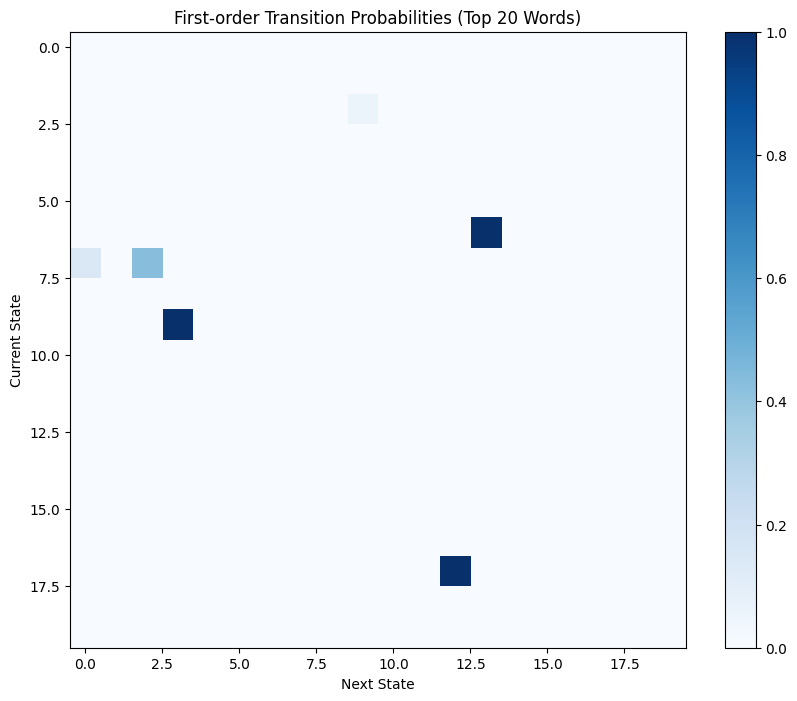

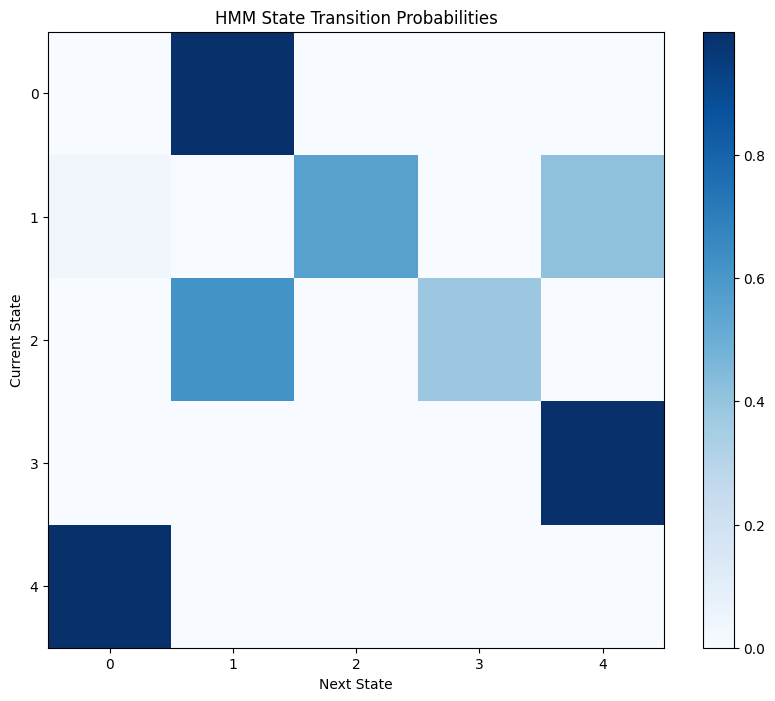

In [48]:
def plot_transition_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Next State')
    plt.ylabel('Current State')
    plt.show()

# Plot first-order transition probabilities
first_order_counts = defaultdict(Counter)
for i in range(len(tokens)-1):
    first_order_counts[tokens[i]][tokens[i+1]] += 1           # it just gets harder and harder to live here.

# Create matrix for first 20 words
top_words = sorted(list(set(tokens)))[:20]
first_order_matrix = np.zeros((len(top_words), len(top_words)))
for i, word1 in enumerate(top_words):
    total = sum(first_order_counts[word1].values())
    for j, word2 in enumerate(top_words):
        first_order_matrix[i,j] = first_order_counts[word1][word2] / total if total > 0 else 0

plot_transition_matrix(first_order_matrix, "First-order Transition Probabilities (Top 20 Words)")

# Plot HMM transition matrix
plot_transition_matrix(model.transmat_, "HMM State Transition Probabilities")